# Homework 2 - balancing & binning (deadline 28. 11. 2021, 23:59)

In short, the main task is to play with balancing and binning to obtain the best results for the binary classification task.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can!

However, we **strongly recommend and require** the following:
* Follow the assignment step by step. Number each step.
* Most steps contain the number of features that should be treated. You can preprocess more features, however, it does not mean that the teacher will give you more points. Focus on quality, not quantity.
* Properly comment all your steps. Comments are evaluated for 2 points of the total together with the final presentation of the solution. However, it is not desirable to write novels! 
* This task is the most challenging of the three, both timewise and computationally. Do not leave it to the last minute.
* Hand in a notebook that has already been run (i.e. do not delete outputs before handing in).

## What are you supposed to do:

  1. Download the dataset [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
  1. Use 2 binning methods (on features of your choice, with your choice of parameters) and comment on its effects on classification performance. _(3 points)_
  1. Use at least 2 other data balancing techniques of your choice on the dataset and comment the classification results. **Just copied code from tutorial 4 will not be accepted.** _(6 points)_
  1. Run all classification tests at least three times - once for unbalanced original data, twice for balanced data (try at least 2 balancing techniques), compare those results and discuss (give a comment). _(5 points)_
  
All your steps and following code **have to be commented!** Comments are evaluated for _2 points_ together with the final presentation of the solution.

**If you do all this properly, you will obtain 16 points.**

## Comments

  * Please follow the technical instructions from https://courses.fit.cvut.cz/NI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, she can (!) give you another chance to rework your homework and to obtain more points. However, this is not a given, so do your best! :)
  * English is not compulsory.
  
## Data description

* The dataset can be downloaded [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
* The data are devoted to the binary classification task, the aim is to predict the probability that a driver will initiate an auto insurance claim in the next year.
* Target feature is called 'y' and signifies whether or not a claim was filed for that policy holder.
* To fulfill the task one does not need to know the meaning of predictors.
* Predictors that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation.
* While using [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), control the shuffling of data by random_state parameter. Do not use shuffle=False, probably never (can cause systematic error).

# Predicting the probability that a driver will initiate an auto insurance claim in the next year

## Ekaterina Simonova - Bioinformatics, UCT 

### Loading libraries &amp; Data

In [ ]:
'''
! sudo apt-get update
! sudo apt-get install -y openjdk-11-jdk
! pip install pyspark
'''

'\n! sudo apt-get update\n! sudo apt-get install -y openjdk-11-jdk\n! pip install pyspark\n'

In [ ]:
# Data handling and processing
import pandas as pd
import numpy as np

# Data visualisation 
import matplotlib.pyplot as plt
import seaborn as sns

# model fine-tuning and evaluation
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

'''
# pyspark modules
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.types import *
from pyspark import SparkContext, SQLContext
'''

# sampling methods
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# importing other modules
import warnings
from collections import Counter

Let's now download the data.

In [ ]:
df = pd.read_csv("data.csv")
df.head()

,y,xind_01,xind_02_cat,xind_03,xind_04_cat,xind_05_cat,xind_06_bin,xind_07_bin,xind_08_bin,xind_09_bin,...,xcalc_11,xcalc_12,xcalc_13,xcalc_14,xcalc_15_bin,xcalc_16_bin,xcalc_17_bin,xcalc_18_bin,xcalc_19_bin,xcalc_20_bin
0,0,2,1,5,1,6,0,1,0,0,...,4,0,2,8,0,0,0,1,1,0
1,0,2,1,6,0,0,0,0,0,1,...,9,2,3,7,0,0,1,0,0,0
2,0,2,1,9,0,0,1,0,0,0,...,5,0,2,6,0,1,0,1,1,0
3,0,1,1,6,0,0,1,0,0,0,...,3,0,4,8,0,0,1,0,0,0
4,0,1,1,5,1,0,0,1,0,0,...,4,3,1,2,0,1,0,0,1,0


### Exploration of the data

Let's first check if data have any null values and check their datatype after loading to environment. 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 58 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   y             595212 non-null  int64  
 1   xind_01       595212 non-null  int64  
 2   xind_02_cat   595212 non-null  int64  
 3   xind_03       595212 non-null  int64  
 4   xind_04_cat   595212 non-null  int64  
 5   xind_05_cat   595212 non-null  int64  
 6   xind_06_bin   595212 non-null  int64  
 7   xind_07_bin   595212 non-null  int64  
 8   xind_08_bin   595212 non-null  int64  
 9   xind_09_bin   595212 non-null  int64  
 10  xind_10_bin   595212 non-null  int64  
 11  xind_11_bin   595212 non-null  int64  
 12  xind_12_bin   595212 non-null  int64  
 13  xind_13_bin   595212 non-null  int64  
 14  xind_14       595212 non-null  int64  
 15  xind_15       595212 non-null  int64  
 16  xind_16_bin   595212 non-null  int64  
 17  xind_17_bin   595212 non-null  int64  
 18  xind

As we can see from above, the dataset mostly contains int and float values. We can also see that it doesn't have any null values. Moreover, some values have sufix bin, which indicate the binary variable, others have suffix cat, I suggest that that was a categorical variable for which one-hot encoding was performed. Y variable might represent a variable which we are going to predict.

Regarding names of columns, there are few unique names - xind/xcar/xreg/xcalc.

Let's first check if y is balanced variable or not.

In [ ]:
df.y.value_counts()

0    573518
1     21694
Name: y, dtype: int64

We can see from above that y is not balanced as value 1 represents only 3.5 % of total data. we can see that our data is highly inbalanced and different techniques should be used to balance it.

By running the notebook, I was running of memory all the time so I could not finish the task, to solve that problem I converted datatypes in the input data to the one which are more memory efficient. It seems like that it helped me to reduce memory usage twice. I found this advice on Medium.com (https://link.medium.com/wSbgxBtmmlb).

In [ ]:
# datatype conversion
float_cols = ["xreg_01", "xreg_02", "xreg_03", "xcar_12", "xcar_13", "xcar_14", "xcar_15", "xcalc_01", "xcalc_02", "xcalc_03"]
int_cols = [i for i in df.columns if i not in float_cols]
float_d = {val: 'float16'for val in float_cols}
int_d = {val: np.uint8 for val in int_cols} 

df = df.astype(float_d)
df = df.astype(int_d)
df.head()

,y,xind_01,xind_02_cat,xind_03,xind_04_cat,xind_05_cat,xind_06_bin,xind_07_bin,xind_08_bin,xind_09_bin,...,xcalc_11,xcalc_12,xcalc_13,xcalc_14,xcalc_15_bin,xcalc_16_bin,xcalc_17_bin,xcalc_18_bin,xcalc_19_bin,xcalc_20_bin
0,0,2,1,5,1,6,0,1,0,0,...,4,0,2,8,0,0,0,1,1,0
1,0,2,1,6,0,0,0,0,0,1,...,9,2,3,7,0,0,1,0,0,0
2,0,2,1,9,0,0,1,0,0,0,...,5,0,2,6,0,1,0,1,1,0
3,0,1,1,6,0,0,1,0,0,0,...,3,0,4,8,0,0,1,0,0,0
4,0,1,1,5,1,0,0,1,0,0,...,4,3,1,2,0,1,0,0,1,0


## Binning data

Let's discretize column xind_15. Let's first look at the distribution of data.

<AxesSubplot:>

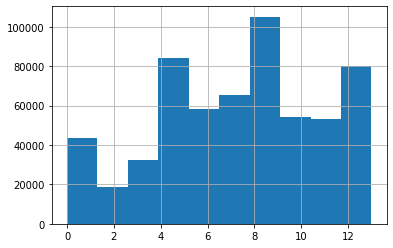

In [ ]:
df.xind_15.hist()

In [ ]:
display(df[['xind_15']].describe())

,xind_15
count,595212.000000
mean,7.299922
std,3.546042
min,0.000000
25%,5.000000
50%,7.000000
75%,10.000000
max,13.000000


We can see that xind_15 variable is continuous and the distribution is not normal we can use cut pandas function in order to bin this column into subcategories. Let's use linspace numpy function to calculate 4 bins equally distributed (by depth).

In [ ]:
min_val, max_val = min_value = df['xind_15'].min(), df['xind_15'].max()
bins = np.linspace(min_val,max_val,4)
bins

array([ 0.        ,  4.33333333,  8.66666667, 13.        ])

In [ ]:
labels = ["low", "medium", "high"]

pd.qcut(df['xind_15'], q=len(bins)-1,  labels=labels).value_counts()

low       237116
high      187663
medium    170433
Name: xind_15, dtype: int64

low       165732
high      131428
medium    119488
Name: x_ind_15_cut, dtype: int64
Training dataset bins:  [ 0.  6.  9. 13.]


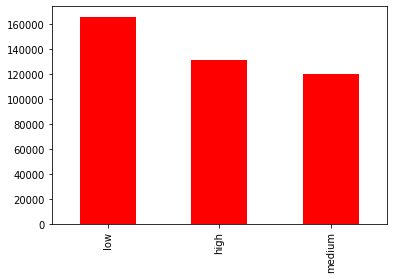

In [ ]:
# separating data to 
bin_df = df.copy()

# Separating the independent variables from dependent variables
X_bin = bin_df.iloc[:,:-1]
y_bin = bin_df.iloc[:,-1]

X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(X_bin,y_bin,test_size=0.30)

# binning into 3 categories
X_train_bin['x_ind_15_cut'], bins_train = pd.qcut(X_train_bin['xind_15'], q=len(bins)-1, labels=labels, retbins=True)
print(X_train_bin.x_ind_15_cut.value_counts())
X_train_bin['x_ind_15_cut'].value_counts().plot(kind="bar", color="r")

print("Training dataset bins: ", bins_train)

low       71384
high      56235
medium    50945
Name: x_ind_15_cut, dtype: int64
Validation dataset bins:  [-inf   6.   9.  inf]


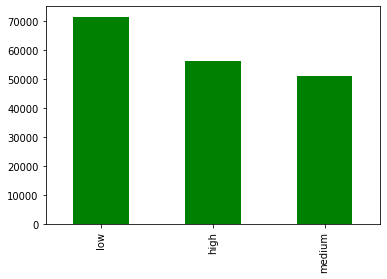

In [ ]:
# binning into 3 categories
bins_test = bins_train
bins_test[0], bins_test[-1] = -np.inf, np.inf
X_val_bin['x_ind_15_cut'] = pd.cut(X_val_bin['xind_15'], bins=bins_test, labels=labels, include_lowest=True) 
print(X_val_bin.x_ind_15_cut.value_counts())
X_val_bin['x_ind_15_cut'].value_counts().plot(kind="bar", color="g")

print("Validation dataset bins: ",bins_test)

In [ ]:
# encoding variables
X_val_bin = pd.get_dummies(X_val_bin, columns = ['x_ind_15_cut'])
X_train_bin = pd.get_dummies(X_train_bin, columns = ['x_ind_15_cut'])

X_val_bin = X_val_bin.drop(['xind_15'], axis=1)
X_train_bin = X_train_bin.drop(['xind_15'], axis=1)

Let's also try to bin values with equal width.

In [ ]:
# preprocessing
bind_df = df.copy()

# Separating the independent variables from dependent variables
X_bind = bind_df.iloc[:,:-1]
y_bind = bind_df.iloc[:,-1]

X_train_bind, X_val_bind, y_train_bind, y_val_bind  = train_test_split(X_bind,y_bind,test_size=0.30)

# binning into 3 categories
X_train_bind['xind_15_cut_d'], dtrain_bins = pd.cut(X_train_bind['xind_15'], bins=bins, precision=1, labels=labels, retbins=True)
print(X_train_bind['xind_15_cut_d'].value_counts())

high      163326
medium    158152
low        72868
Name: xind_15_cut_d, dtype: int64


<AxesSubplot:>

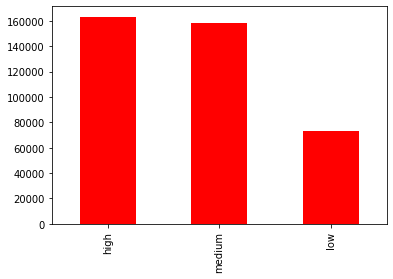

In [ ]:
X_train_bind['xind_15_cut_d'].value_counts().plot(kind="bar", color="r")

high      69834
medium    67745
low       31461
Name: xind_15_cut_d, dtype: int64


<AxesSubplot:>

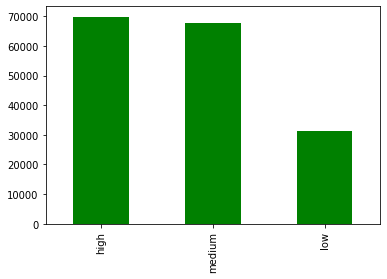

In [ ]:
# binning into 3 categories
X_val_bind['xind_15_cut_d'] = pd.cut(X_val_bind['xind_15'], bins=dtrain_bins, precision=1, labels=labels)
print(X_val_bind['xind_15_cut_d'].value_counts())
X_val_bind['xind_15_cut_d'].value_counts().plot(kind="bar", color="g")

In [ ]:
# encoding variables
X_val_bind = pd.get_dummies(X_val_bind, columns = ['xind_15_cut_d'])
X_train_bind = pd.get_dummies(X_train_bind, columns = ['xind_15_cut_d'])

X_val_bind = X_val_bind.drop(['xind_15'], axis=1)
X_train_bind = X_train_bind.drop(['xind_15'], axis=1)

### Model evaluation

Let's now create a function which we will use for classification of our dataset. I first tried to run the data with scikit learn, it was too slow (I was trying to use more classification methods though later you commented in chat that one is enough) that's why I decide to use pyspark for running models.However with pyspark I got into memory issue very fast as I needed to convert pandas dataframe to pyspark dataframe. I stopped using pyspark and switched back to scikit-learn. My pyspark solution os shown below it worked nicely (Logistic regression on data was running for just 2 minutes while with scikit-learn it took over 20 minutes to run).

In [ ]:
# defining function to run the model
def run_model(X_train, y_train, X_val, y_val):
    model = DecisionTreeClassifier()
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # metrics definition
    f1score = f1_score(y_val, y_pred)
    auc_score = roc_auc_score(y_val, y_pred, average=None)
    conf_matrix = confusion_matrix(y_val, y_pred)

    results = f'F1-score: {f1score} \nAUC score: {auc_score}\nConfusion matrix: \n {conf_matrix}'
    return results

### Running the model without any preprocessing

In [ ]:
# Separating the independent variables from dependent variables
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.30)

print(f'Model: ', 'Decision Tree - No preprocessing')
print(run_model(X_train, y_train, X_val, y_val))

Model:  Decision Tree - No preprocessing
F1-score: 0.1657027572293208 
AUC score: 0.5001241056350624
Confusion matrix: 
 [[124012  27164]
 [ 22460   4928]]


### Running the model with binning (equal width)

In [ ]:
print('Model: ', 'Decision Tree - binning width')
print(run_model(X_train_bin, y_train_bin, X_val_bin, y_val_bin))

Model:  Decision Tree - binning width
F1-score: 0.16927487352445197 
AUC score: 0.5026525870756023
Confusion matrix: 
 [[124283  26846]
 [ 22416   5019]]


### Running the model with binning (equal depth)

In [ ]:
print('Model: ', 'Decision Tree - binning depth')
print(run_model(X_train_bind, y_train_bind, X_val_bind, y_val_bind))

Model:  Decision Tree - binning depth
F1-score: 0.16606766219522484 
AUC score: 0.5007330672252518
Confusion matrix: 
 [[124220  27041]
 [ 22382   4921]]


From above we can se that F1-score a little bit improved while preprocessing the column with equal width binning. AUC score did not change. The confusion matrix changed with a lower extend.

## Balancing data

In this part, I decided to use 2 balancing techniques one for under-sampling (Random under-sampling) and one for over-sampling (Random over-sampling).

### Random under-sampling

In [ ]:
# Separating the independent variables from dependent variables
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Split train-test data
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.30)

print("Before undersampling: ", Counter(y_train))

undersample = RandomUnderSampler(sampling_strategy='majority')

X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

print("After undersampling: ", Counter(y_train_under))

print('Model: ', 'Decision Tree - Random undersampling')
print(run_model(X_train_under, y_train_under,  X_val, y_val))

Before undersampling:  Counter({0: 352670, 1: 63978})
After undersampling:  Counter({0: 63978, 1: 63978})
Model:  Decision Tree - Random undersampling
F1-score: 0.23581400537150013 
AUC score: 0.5022619654096759
Confusion matrix: 
 [[75764 75521]
 [13538 13741]]


### Random over-sampling

In [ ]:
print("Before oversampling: ", Counter(y_train))

oversampling = RandomOverSampler()

X_train_o, y_train_o = oversampling.fit_resample(X_train, y_train)

print("After oversampling: ", Counter(y_train_o))

print('Model: ', 'Decision Tree - Random over-sampling')
print(run_model(X_train_o, y_train_o,  X_val, y_val))

Before oversampling:  Counter({0: 352670, 1: 63978})
After oversampling:  Counter({0: 352670, 1: 352670})
Model:  Decision Tree - Random over-sampling
F1-score: 0.15666631141425982 
AUC score: 0.49949816357652355
Confusion matrix: 
 [[126676  24609]
 [ 22869   4410]]


We can see that random undersampling did not change AUC score however it improved F1-score. We can also see that the number of FN calls decreased and FP calls increased compare to classification without any preprocessing. No change in F, score and AUC score was observed when we compare classification without preprocessing and classification with random oversampling.

## Running classification test 

In [ ]:
def build_clf_model(X_train, y_train, x_test, y_test):
     
    param_grid = {
    'max_depth': range(1,20,3),
    'criterion': ['entropy', 'gini']}

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=333)

    grid = GridSearchCV(estimator=DecisionTreeClassifier(),
                        param_grid=param_grid,
                        scoring='f1',
                        n_jobs=-1)
    # Fit grid to the training data
    grid.fit(X_train, y_train)
    # Extract best model from grid
    best_model = grid.best_estimator_

    prediction = best_model.predict(x_test)

    cnf_matrix = confusion_matrix(y_test, prediction)
    f1 = f1_score(y_test, prediction)

    print('Best hyperparameters:',grid.best_params_,'\nConfusion matrix:', cnf_matrix, '\nF1-score:', f1)

### Running the model without any preprocessing

In [ ]:
print(f'Model: ', 'Decision Tree - No preprocessing')
print(build_clf_model(X_train, y_train, X_val, y_val))

Model:  Decision Tree - No preprocessing
Best hyperparameters: {'criterion': 'gini', 'max_depth': 19} 
Confusion matrix: [[148186   3099]
 [ 26734    545]] 
F1-score: 0.03524884390259676
None


### Running the model with random under-sampling

In [ ]:
print('Model: ', 'Decision Tree - Random undersampling')
print(build_clf_model(X_train_under, y_train_under, X_val, y_val))

Model:  Decision Tree - Random undersampling
Best hyperparameters: {'criterion': 'gini', 'max_depth': 10} 
Confusion matrix: [[57833 93452]
 [10484 16795]] 
F1-score: 0.2442447246338874
None


### Running the model with random over-sampling

In [ ]:
print('Model: ', 'Decision Tree - Random oversampling')
print(build_clf_model(X_train_o, y_train_o, X_val, y_val))

Model:  Decision Tree - Random oversampling
Best hyperparameters: {'criterion': 'gini', 'max_depth': 19} 
Confusion matrix: [[72866 78419]
 [13080 14199]] 
F1-score: 0.23685329908171177
None


From above we can observe that modeling of data without any preprocessing returned better results than preprocessing of data with under or oversampling. The conclusion is based on F1-score.

### Running the model with binning (width)

In [ ]:
print('Model: ', 'Decision Tree - Binning with width')
print(build_clf_model(X_train_bin, y_train_bin, X_val_bin, y_val_bin))

Model:  Decision Tree - Binning with width
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 19} 
Confusion matrix: [[148350   2779]
 [ 26897    538]] 
F1-score: 0.03498959417273674
None


From above we can see that preprocessing of data with binning results in better F1-score than preprocessing with over/under sampling. 

### Binning &amp; Balancing - combined solution

Let's try to combine binning and balancing to see if it can improve the classification model.

In [ ]:
print("Before undersampling: ", Counter(y_train_bin))

X_train_under_bin, y_train_under_bin = undersample.fit_resample(X_train_bin, y_train_bin)

print("After undersampling: ", Counter(y_train_under_bin))

print('Model: ', 'Decision Tree - Random undersampling & Balancing (width)')
print(build_clf_model(X_train_under_bin, y_train_under_bin, X_val_bin, y_val_bin))

Before undersampling:  Counter({0: 352826, 1: 63822})
After undersampling:  Counter({0: 63822, 1: 63822})
Model:  Decision Tree - Random undersampling & Balancing (width)
Best hyperparameters: {'criterion': 'gini', 'max_depth': 13} 
Confusion matrix: [[84778 66351]
 [15286 12149]] 
F1-score: 0.2293670647094917
None


Combination of two approaches - undersampling & binning did not help to improve F1-score.

## Pyspark solution

In [ ]:
# defining function for evaluation 
def log_reg_model(input_model, train_data, test_data):

    spark = SparkSession.builder.appName('pandasToSparkDF').getOrCreate()

    assembler = VectorAssembler(outputCol="features")
    assembler.setInputCols(train_data.columns)
    
    pipeline = Pipeline(stages=[assembler, input_model])

    model = pipeline.fit(train_spark)

    predictions = model.transform(test_spark)

    trainingSummary = model.stages[-1].summary

    AUC_train = trainingSummary.areaUnderROC
    accuracy_train = trainingSummary.accuracy

    evaluator = BinaryClassificationEvaluator(labelCol='y')
    AUC_test = evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})

    evaluator = MulticlassClassificationEvaluator(labelCol='y')
    accuracy_test = evaluator.evaluate(predictions, {evaluator.metricName: 'accuracy'})

    result = "Training dataset AUC: %s\n Testing dataset AUC: %s\nTraining dataset - accuracy: %s\n Testing dataset - accuracy: %s" % (AUC_train, AUC_test, accuracy_train, accuracy_test)

    return result

To perform the conversion of pandas dataframe to spark dataframe I will use functions given below. These functions were taken from gist - https://gist.github.com/zaloogarcia/11508e9ca786c6851513d31fb2e70bfc.

In [ ]:
# creating mySchema
def equivalent_type(f):
    if f == 'datetime64[ns]': return DateType()
    elif f == 'int64': return LongType()
    elif f == 'int32': return IntegerType()
    elif f == 'uint8': return IntegerType()
    elif f == 'float64': return FloatType()
    else: return StringType()

def define_structure(string, format_type):
    try: typo = equivalent_type(format_type)
    except: typo = StringType()
    return StructField(string, typo)

#Given pandas dataframe, it will return a spark's dataframe
def pandas_to_spark(df_pandas):
    sqlContext = SQLContext(SparkContext.getOrCreate())
    columns = list(df_pandas.columns)
    types = list(df_pandas.dtypes)
    struct_list = []
    for column, typo in zip(columns, types): 
        struct_list.append(define_structure(column, typo))
    p_schema = StructType(struct_list)
    return sqlContext.createDataFrame(df_pandas, p_schema)

### Running the model without any preprocessing

In [ ]:
'''
pyspark_df = pandas_to_spark(df)

spark_models = {'Logistic regression' : LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, featuresCol='features', labelCol='y')}

train_spark, test_spark = pyspark_df.randomSplit(weights=[0.7,0.3], seed=200)

for key, val in spark_models.items():
    print('Model: ', key)
    print(log_reg_model(val, train_spark, test_spark), end='\n\n')
'''

"\npyspark_df = pandas_to_spark(df)\n\nspark_models = {'Logistic regression' : LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, featuresCol='features', labelCol='y')}\n\ntrain_spark, test_spark = pyspark_df.randomSplit(weights=[0.7,0.3], seed=200)\n\nfor key, val in spark_models.items():\n    print('Model: ', key)\n    print(log_reg_model(val, train_spark, test_spark), end='\n\n')\n"

### Running the model with binning (depth)

In [ ]:
'''
df_bind = bind_df.drop(['xind_15'], axis=1)
df_bind = pd.get_dummies(df_bind, columns=["xind_15_cut_d"])

pyspark_bind = pandas_to_spark(df_bind)

train_spark_d, test_spark_d = pyspark_bind.randomSplit(weights=[0.7,0.3], seed=200)

for key, val in spark_models.items():
    print('Model: ', key)
    print(log_reg_model(val, train_spark_d, test_spark_d), end='\n\n')
'''

'\ndf_bind = bind_df.drop([\'xind_15\'], axis=1)\ndf_bind = pd.get_dummies(df_bind, columns=["xind_15_cut_d"])\n\npyspark_bind = pandas_to_spark(df_bind)\n\ntrain_spark_d, test_spark_d = pyspark_bind.randomSplit(weights=[0.7,0.3], seed=200)\n\nfor key, val in spark_models.items():\n    print(\'Model: \', key)\n    print(log_reg_model(val, train_spark_d, test_spark_d), end=\'\n\n\')\n'

### Running the model with binning (width)

In [ ]:
'''
df_bin = bin_df.drop(['xind_15'], axis=1)
df_bin = pd.get_dummies(df_bind, columns=["x_ind_15_cut"]) 

#pyspark_bin = pandas_to_spark(df_bin)

#train_spark_w, test_spark_w = pyspark_bin.randomSplit(weights=[0.7,0.3], seed=200)

#for key, val in spark_models.items():
#    print('Model: ', key)
#    print(log_reg_model(val, train_spark_w, test_spark_w), end='\n\n')


SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-34-06c2d879c373>, line 11)

**Personal notes and conclusion:**

* I tried to use SMOTE as oversampling method in addition to those I used however I run out of memory (unprocessed pandas df - default dtype). SMOTE and oversampling were giving me simillar results.

* Pyspark along with pandas (unprocessed pandas df - default dtype) was using a lot of memory, I wanted to learn in this exercise how to use pyspark.

* The speed of the code (due to the size of dataset was quite slow) I couldn't try some other classification models on these data, I was curious which model would work the best. I chose DecisionTree as it was fast to run.

* Binning of data to have the equal with help to improve the performance of the classification model. 

* None of techniques used to equalize the number of predictable variable (oversampling/undersampling) did not help to improve F1-score and the number of False positive and False negative calls.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c2a71827-6cde-4962-96a5-e524371dd981' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>